In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
#dataset = 'data10102019'
dataset = "20042014"
f = netcdf_file(f"{dataset}.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f0b25701a30>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f0afd077e50>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f0afd077e80>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f0afd077f10>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f0afd077fa0>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d0a0>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d130>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d1c0>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d310>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d3a0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d460>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d4f0>,
 'longitude': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d550>,
 'err_sla': <scipy.io._netcdf.netcdf_variable at 0x7f0afd07d5e0>}

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

320
(320, 81)


In [4]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

interp_vel_x = RegularGridInterpolator((i, j), imputed_vel_x, method=method)
interp_vel_y = RegularGridInterpolator((i, j), imputed_vel_y, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, *, steps, step_size, dist_tol, winding_tol):
    #print(i,j, flush=True)
    winding_angle = 0
    theta_prev = 0
    closed = False
    
    start_i = i
    start_j = j
    
    # streamline path
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            # get velocities
            v = rhs(0,[i,j])
        except:
            # stream line leaves domain
            break
        
        # integrate
        i += step_size*v[1]
        j += step_size*v[0]
        
        # get angle
        theta = np.arctan2(v[1], v[0])
        
        if k > 1:
            winding_angle += theta - theta_prev
           
        if k > 100 and (dist:=euclidean([i,j],[start_i,start_j])) < dist_tol:
            closed = True
            break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    if (winding_angle % (2*np.pi) < winding_tol or winding_angle % (-2*np.pi) < winding_tol) and closed:
        print(f"{dist=} {winding_angle=} {closed=}")
        return np.asarray(trajectory).T
    return None
        
        
from multiprocessing import Pool
from functools import partial
from itertools import product

step = 5

i_points = range(0, imputed_vel_x.shape[0], step)
j_points = range(0, imputed_vel_x.shape[1], step)

with Pool() as p:
    func = partial(streamline, steps=5000, step_size=0.1, dist_tol=0.3, winding_tol=0.3)
    
    res = p.starmap(func, product(i_points,j_points))

eddies = []

for result in res:
    if result is not None:
        eddies.append(np.mean(result, axis=-1))

eddies = np.asarray(eddies)


dist=0.23354578363286463 winding_angle=-0.21860138777387228 closed=Truedist=0.26310878290741924 winding_angle=-0.20643153754478627 closed=Truedist=0.1817424902533518 winding_angle=-0.05687386131015082 closed=True


dist=0.2973414024695711 winding_angle=-0.3439993265376887 closed=True
dist=0.15562607182255245 winding_angle=5.577095285088603 closed=True
dist=0.2991950170427632 winding_angle=-0.006502301287555579 closed=True
dist=0.21301467528390794 winding_angle=-0.045774131935883755 closed=True
dist=0.2989226874647778 winding_angle=-0.2928755456085823 closed=True
dist=0.15864879211444194 winding_angle=0.009436289452961877 closed=True
dist=0.2958188430327329 winding_angle=0.010282789802396719 closed=True
dist=0.29882517112969265 winding_angle=-0.0825642359246539 closed=True
dist=0.19761203551266965 winding_angle=-0.07596149423889509 closed=True
dist=0.2971927085605669 winding_angle=-0.0014182337408161771 closed=True
dist=0.2993848989764619 winding_angle=-0.09480608870920226 closed=True
d

dist=0.29214363086162387 winding_angle=0.3204271603908493 closed=True
dist=0.28486933631884603 winding_angle=0.013487995453187046 closed=True
dist=0.29362983585021774 winding_angle=-0.12175415416967184 closed=True
dist=0.276560288869166 winding_angle=0.15767509745475983 closed=True
dist=0.29382713690270085 winding_angle=0.16686343962657368 closed=True
dist=0.2960376643827547 winding_angle=-0.11645490368773359 closed=True
dist=0.2892667427875457 winding_angle=0.067498675294176 closed=True
dist=0.29763931672839966 winding_angle=-0.16688537791177738 closed=True
dist=0.18157368939901267 winding_angle=-0.4127495316631987 closed=True
dist=0.297735995717275 winding_angle=0.0834312259590404 closed=True
dist=0.29778881980204086 winding_angle=0.2943104330887478 closed=True
dist=0.29808585156253126 winding_angle=-0.051728013093499836 closed=True
dist=0.28717097842846834 winding_angle=0.008545640440210445 closed=True
dist=0.29618098845787477 winding_angle=-0.09592704723336554 closed=True
dist=0.29

<IPython.core.display.Javascript object>


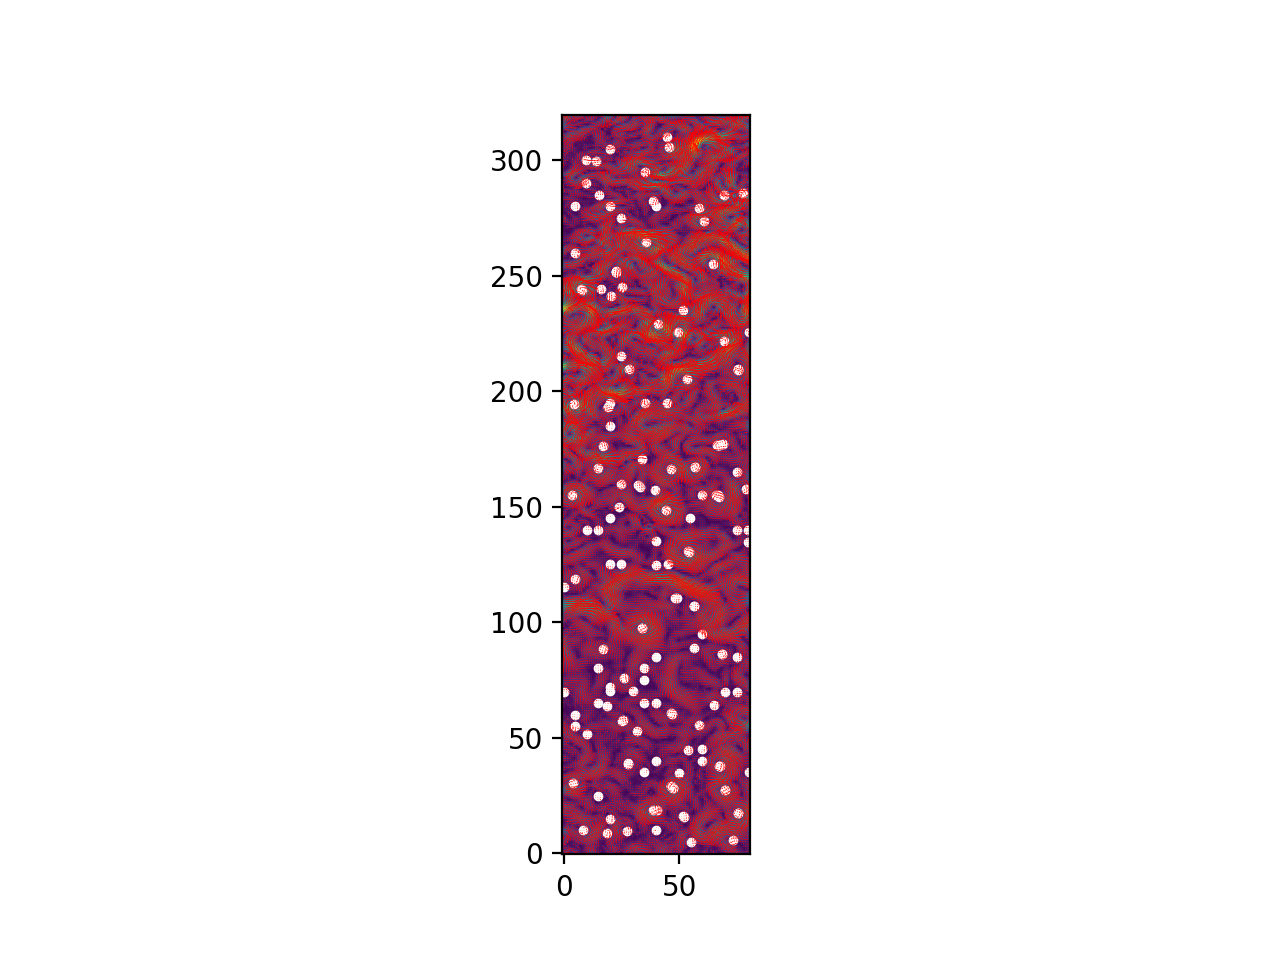

In [5]:
plt.figure(dpi = 200)
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
plt.plot(eddies[:,1], eddies[:,0], 'w.', markersize=5, label="Eddy Centre")
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5, zorder=2)

In [6]:
from scipy.interpolate import RegularGridInterpolator

m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

latm, longm = np.meshgrid(lat, long, indexing='ij')

interp_lat = RegularGridInterpolator((i, j), latm, method=method)
interp_long = RegularGridInterpolator((i, j), longm, method=method)

np.savetxt(f"windingangle-{dataset}.csv",np.column_stack([interp_lat(eddies), interp_long(eddies)]), delimiter=',')